This example is created by Stephen Cini, inspired by example in Montana's manuscript and advice from Dr. Alex Dowling. Purpose is to test multistart function's ability to find local minima.

**Equation:**  
    $$f(x, \theta) = (\theta_1  x^3 - \theta_2 x^2 + 2x - 1)^2 + (\theta_1 - \theta_2)^2 + (x^2 - 1)^2$$ 
$\qquad f(x, \theta)\rightarrow$ (response / output variable)  
$\qquad \theta_1, \theta_2 \rightarrow$ parameters  
$\qquad x\rightarrow$ (control / decision variable)  

**Data:**  
<table>
  <thead>
    <tr>
      <th>Substrate</th>
      <th colspan="2">Velocity</th>
    </tr>
    <tr>
      <th>Concentration</th>
      <th colspan="2">(counts/min<sup>2</sup>)</th>
    </tr>
    <tr>
      <th>(ppm)</th>
      <th>(a) Treated</th>
      <th>(b) Untreated</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.02</td>
      <td style="vertical-align: top; text-align: center;">76 <br> 47</td>
      <td style="vertical-align: top; text-align: center;">67 <br> 51</td>
    </tr>
    <tr>
      <td>0.06</td>
      <td style="vertical-align: top; text-align: center;">97 <br> 107</td>
      <td style="vertical-align: top; text-align: center;">84 <br> 86</td>
    </tr>
    <tr>
      <td>0.11</td>
      <td style="vertical-align: top; text-align: center;">123 <br> 139</td>
      <td style="vertical-align: top; text-align: center;">98 <br> 115</td>
    </tr>
    <tr>
      <td>0.22</td>
      <td style="vertical-align: top; text-align: center;">159 <br> 152</td>
      <td style="vertical-align: top; text-align: center;">131 <br> 124</td>
    </tr>
    <tr>
      <td>0.56</td>
      <td style="vertical-align: top; text-align: center;">191 <br> 201</td>
      <td style="vertical-align: top; text-align: center;">144 <br> 158</td>
    </tr>
    <tr>
      <td>1.10</td>
      <td style="vertical-align: top; text-align: center;">207 <br> 200</td>
      <td style="vertical-align: top; text-align: center;">160</td>
    </tr>
  </tbody>
</table>

[Find data or remove table]

# Importing packages

In [1]:
# Get version of pyomo

# Force reload of pyomo module to ensure we get the latest version
import importlib
import pyomo # your .py file without the .py extension
importlib.reload(pyomo)
print("Pyomo version after reload:")
print(pyomo.__version__)
print("pyomo.__file__:", pyomo.__file__)

import pyomo.environ as pyo


Pyomo version after reload:
6.9.3.dev0
pyomo.__file__: /Users/scini/Documents/GitHub/pyomo/pyomo/__init__.py


In [2]:
import numpy as np
import scipy
import seaborn as sns  # This package is only needed for pairplot
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import pyomo.contrib.parmest.parmest as parmest # import parmest
import pyomo.contrib.parmest.experiment as experiment
import pyomo.contrib.doe as doe
import pandas as pd
from itertools import product
import idaes

# Data
Data for this model in Montana's manuscript was generated by simulating the model with true parameter values and adding 1% Gaussian error. So this is replicated here.

In [3]:
# True param values
true_params = {
    'theta1': -1.5,
    'theta2': 0.5,
}

# $$f(x, \theta) = (\theta_1  x^3 - \theta_2 x^2 + 2x - 1)^2 + (\theta_1 - \theta_2)^2 + (x^2 - 1)^2$$ 

def model(x, theta1, theta2):
    return ((theta1 * x**3 - theta2 * x**2 + 2 * x - 1)**2 +
            (theta1 - theta2)**2 +
            (x**2 - 1)**2)

def generate_data(num_samples=1000):
    x_values = np.linspace(-4, 4, num_samples)
    y_values = np.array([model(x, true_params['theta1'], true_params['theta2']) for x in x_values])

    # Add 1% Gaussian noise to the y values
    noise = np.random.normal(0, 0.01 * np.abs(y_values), size=y_values.shape)
    y_values += noise
    # Create a DataFrame with the x and y values
    # and return it
    return pd.DataFrame({'x': x_values, 'y': y_values})



Data generated with 1000 samples.
          x            y
0 -4.000000  6515.412188
1 -3.991992  6367.720590
2 -3.983984  6257.737250
3 -3.975976  6182.891231
4 -3.967968  6013.270490


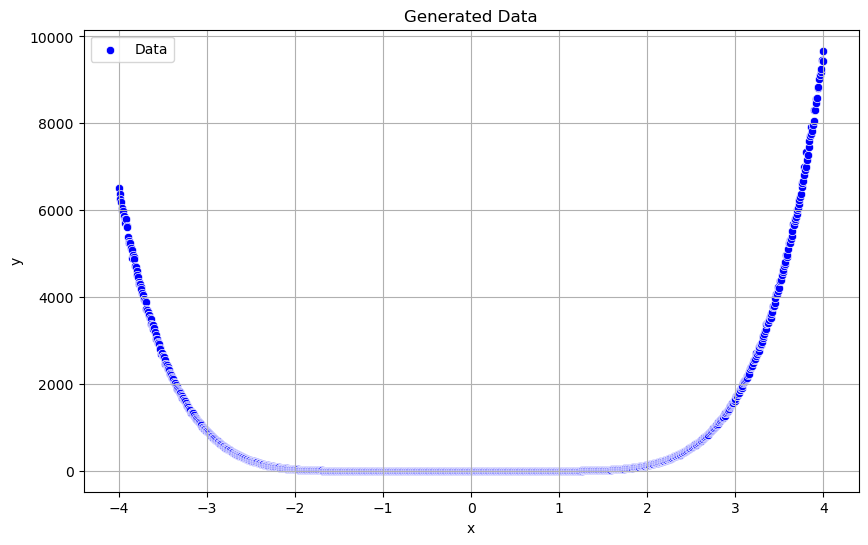

In [4]:
# Make some data
data_df = generate_data()
print("Data generated with {} samples.".format(len(data_df)))

print(data_df.head())

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_df, x='x', y='y', color='blue', label='Data')
plt.title('Generated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [5]:
conc = data_df['x'].values
vel = data_df['y'].values

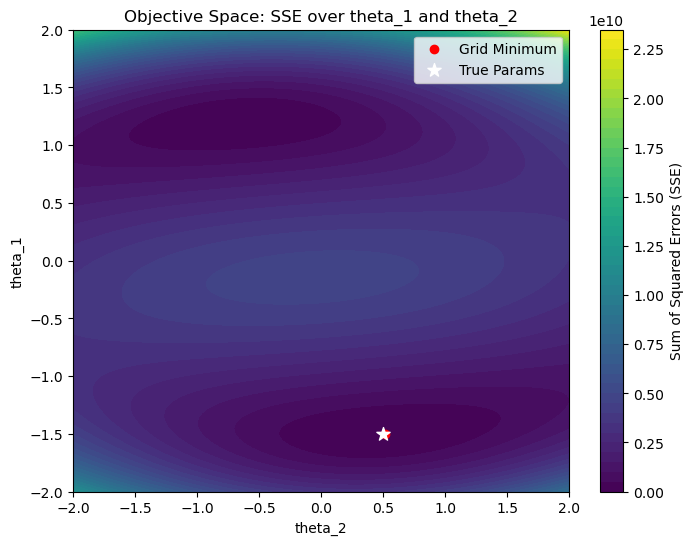

In [6]:
# Analyze the objective space by evaluating the sum of squared errors (SSE)
# over a grid of theta_1 and theta_2 values
theta1_range = np.linspace(-2, 2, 200)
theta2_range = np.linspace(-2, 2, 200)
sse_grid = np.zeros((len(theta1_range), len(theta2_range)))

# Use the model function from cell 5
for i, t1 in enumerate(theta1_range):
    for j, t2 in enumerate(theta2_range):
        y_sim = np.array([model(x, t1, t2) for x in conc])
        sse = np.sum((vel - y_sim) ** 2)
        sse_grid[i, j] = sse

# Plot the objective space
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(theta2_range, theta1_range)
cp = plt.contourf(X, Y, sse_grid, levels=50, cmap='viridis')
plt.colorbar(cp, label='Sum of Squared Errors (SSE)')
plt.xlabel('theta_2')
plt.ylabel('theta_1')
plt.title('Objective Space: SSE over theta_1 and theta_2')
# Optionally, mark the minimum SSE location on the grid
min_idx = np.unravel_index(np.argmin(sse_grid), sse_grid.shape)
plt.scatter([theta2_range[min_idx[1]]], [theta1_range[min_idx[0]]], color='red', label='Grid Minimum')
plt.scatter([true_params['theta2']], [true_params['theta1']], color='white', marker='*', s=100, label='True Params')
plt.legend()
plt.show()

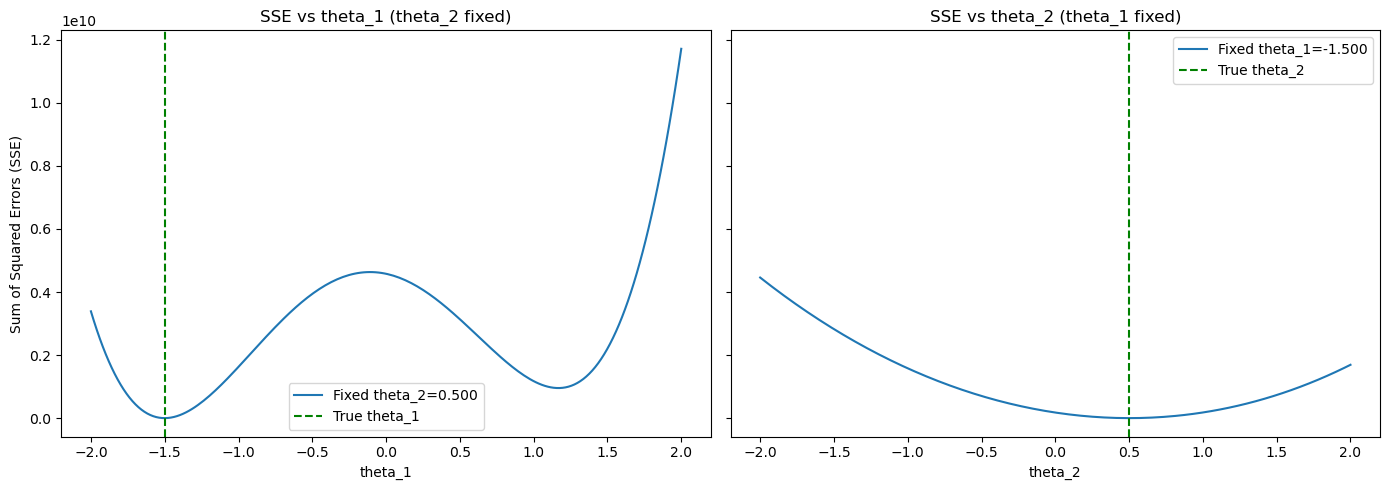

In [7]:
# Plot the effect of varying each parameter (theta_1 and theta_2) one at a time

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Vary theta_1, fix theta_2 at true value
theta1_vals = theta1_range
theta2_fixed = true_params["theta2"]
sse_theta1 = []
for t1 in theta1_vals:
    y_sim = np.array([model(x, t1, theta2_fixed) for x in conc])
    sse = np.sum((vel - y_sim) ** 2)
    sse_theta1.append(sse)
axes[0].plot(theta1_vals, sse_theta1, label=f'Fixed theta_2={theta2_fixed:.3f}')
axes[0].axvline(true_params['theta1'], color='green', linestyle='--', label='True theta_1')
axes[0].set_xlabel('theta_1')
axes[0].set_ylabel('Sum of Squared Errors (SSE)')
axes[0].set_title('SSE vs theta_1 (theta_2 fixed)')
axes[0].legend()

# Vary theta_2, fix theta_1 at true value
theta2_vals = theta2_range
theta1_fixed = true_params["theta1"]
sse_theta2 = []
for t2 in theta2_vals:
    y_sim = np.array([model(x, theta1_fixed, t2) for x in conc])
    sse = np.sum((vel - y_sim) ** 2)
    sse_theta2.append(sse)
axes[1].plot(theta2_vals, sse_theta2, label=f'Fixed theta_1={theta1_fixed:.3f}')
axes[1].axvline(true_params['theta2'], color='green', linestyle='--', label='True theta_2')
axes[1].set_xlabel('theta_2')
axes[1].set_title('SSE vs theta_2 (theta_1 fixed)')
axes[1].legend()

plt.tight_layout()
plt.show()


# PARMEST

## Creating an experiment class for both DOE and ParmEst
We will use this class for both parmest (to estimate the parameters) and DOE (To calculate the FIM and factorial design)

In [8]:
class Simple_Multimodal(experiment.Experiment):

    # Defining the constructor for our model
    def __init__(self, data, theta_initial=None):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            theta_initial: initial guess of the parameter values, dtype: dict. pass the values as theta_initial = {1 : <theta_1 initial value>, 2 : <theta_2 initial value>}
                default:  {1: 100, 2: 0.05}
                
        """
        self.conc = data["x"]
        self.vel = data["y"]
        self.model = None  
        self.theta_initial = theta_initial
        if self.theta_initial is None:
            self.theta_initial = {1: -1.5, 2: 0.5}  # default initial guess of theta[1] & theta[2]
        else:
            self.theta_initial = theta_initial

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints.
        The index set for data points will be the actual substrate concentrations (x values).
        """
        m = self.model = pyo.ConcreteModel()

        # theta_1 and theta_2 as parameters to be estimated
        m.theta_1 = pyo.Var(initialize=self.theta_initial[1], bounds=(-2, 2))
        m.theta_2 = pyo.Var(initialize=self.theta_initial[2], bounds=(-2, 2))

        # Use the actual conc values as the index set
        m.x_set = pyo.Set(initialize=[float(val) for val in self.conc], ordered=True)

        # Substrate concentration (x) as a parameter, indexed by x_set
        m.x = pyo.Param(m.x_set, initialize={float(val): float(val) for val in self.conc}, mutable=False)

        # Measured variable for each data point (indexed by x_set)
        m.measured_var = pyo.Var(m.x_set)

        # Constraint for each data point
        def meas_con(m, xval):
            return m.measured_var[xval] == (m.theta_1 * m.x[xval]**3 - m.theta_2 * m.x[xval]**2 + 2 * m.x[xval] - 1)**2 + (m.theta_1 - m.theta_2)**2 + (m.x[xval]**2 - 1)**2
        m.meas_con = pyo.Constraint(m.x_set, rule=meas_con)

        # Objective function: sum of squared errors over all data points
        m.FirstStageCost = pyo.Expression(initialize=0)
        m.SecondStageCost = pyo.Expression(expr=sum((self.vel[i] - m.measured_var[float(self.conc[i])]) ** 2 for i in range(len(self.conc))))
        m.Total_Cost_Obj = pyo.Objective(expr=(m.FirstStageCost + m.SecondStageCost), sense=pyo.minimize)

        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.theta_1.fix(self.theta_initial[1]) 
        m.theta_2.fix(self.theta_initial[2]) 


        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.measured_var, self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m.x, None)])``.
        # Output is not important for ``DOE``

        # m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # # m.experiment_inputs[m.x] = self.conc
        # m.experiment_inputs.update([(m.x, self.conc)])
        # # If we only use ``DOE``, we could use ``m.experiment_inputs.update([(m.x, None)])``

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta_1, m.theta_2])
        # m.unknown_parameters[m.theta_1]= self.theta_initial[1]
        # m.unknown_parameters[m.theta_2]= self.theta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.measured_var] = 0.03
        m.measurement_error.update([(m.measured_var, 0.03**2)])  # variance of the measurement error, b/c in doe, the measurement error is passed as variance, not std
        # this will be fixed in later update 

        return m

## Parmest Example
We will evaluate diffent parameters, visualize pairwise plots and show bootstrap table

### Treated velocity
Here, we will calculate objective value at optimum parameter value, paramater values, $\theta$, and covariance matrix for treated velocity.

In [9]:
exp_list = []  
conc = data_df["x"].values  # substrate concentration (control variable)
vel = data_df["y"].values  # reaction velocity (output variable)
n_exp = 1

# exp_list to separate each experiment
# for i in range(n_exp):
exp_list.append(Simple_Multimodal(data_df))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = True)  

# Estimating d
obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=len(conc),)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want
cov_perm = cov.loc[t_order, t_order]  # ``covariance`` matrix in the order we want

print("\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov_perm)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

### Manual multistart test

Made a for loop version of multistart, to see expected results from solver being accessed each time. Sobol sampling, n = 50, seed = 12345

In [10]:

# Run parmest estimation for multiple random initial guesses of theta within bounds

num_runs = 50  # Number of random initializations
theta_names = ['theta_1', 'theta_2']
theta1_bounds = (-2, 2)
theta2_bounds = (-2, 2)

results = []

for run in range(num_runs):
    # Sobol sampling for initial values
    if run == 0:
        sampler = scipy.stats.qmc.Sobol(d=len(theta_names), seed = 12345)
        sobol_samples = sampler.random(num_runs + 1)[1:]
        sobol_theta1 = theta1_bounds[0] + (theta1_bounds[1] - theta1_bounds[0]) * sobol_samples[:, 0]
        sobol_theta2 = theta2_bounds[0] + (theta2_bounds[1] - theta2_bounds[0]) * sobol_samples[:, 1]
    theta1_init = sobol_theta1[run]
    theta2_init = sobol_theta2[run]
    theta_initial = {1: theta1_init, 2: theta2_init}
    # Create experiment and estimator
    exp = Simple_Multimodal(data_df, theta_initial=theta_initial)
    pest = parmest.Estimator([exp], tee=True)
    
    # Estimate parameters
    obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=len(conc))
    results.append({
        'run': run,
        'theta1_init': theta1_init,
        'theta2_init': theta2_init,
        'theta1_est': theta['theta_1'],
        'theta2_est': theta['theta_2'],
        'objective': obj
    })

# Convert results to DataFrame for inspection
random_init_results_df = pd.DataFrame(results)
print(random_init_results_df)

# Print unique values of estimated parameters
print("\nUnique estimated theta_1 values:")
print(random_init_results_df['theta1_est'].unique())
print("\nUnique estimated theta_2 values:")
print(random_init_results_df['theta2_est'].unique())


Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

/Applications/anaconda3/envs/parmest-dev-mac2/lib/python3.13/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

In [11]:
# # Print the model ef_instance from the Estimator
# ef_instance = pest.ef_instance

# ef_instance.pprint()

### Integrated Multistart test

Now checking results against embedded feature version of multistart. Same settings

In [12]:
exp_list = []  
conc = data_df["x"].values  # substrate concentration (control variable)
vel = data_df["y"].values  # reaction velocity (output variable)
n_exp = 1

# exp_list to separate each experiment
# for i in range(n_exp):
exp_list.append(Simple_Multimodal(data_df))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = True)  

# obj, theta = pest.theta_est()
results_df = pest.theta_est_multistart(multistart_sampling_method="sobol", n_restarts=50, seed = 12345)

print("\n\nResults DataFrame:")
print(results_df)

# # Print unique parameter values
print("\nUnique converged_theta_1 values:", results_df['converged_theta_1'].unique())
print("Unique converged_theta_2 values:", results_df['converged_theta_2'].unique())

Starting multistart optimization with 50 restarts using sobol sampling method.
Setting theta_2 to -1.570499699562788
Current value of theta_1 is 0.9041174054145813
Current value of theta_2 is -1.570499699562788
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publici

/Applications/anaconda3/envs/parmest-dev-mac2/lib/python3.13/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/scini/Documents/GitHub/pyomo/pyomo/contrib/parmest/parmest.py:1208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.at[i, f'converged_{name}'] = converged_theta[j] if not np.isnan(converged_theta_vals[i, j]) else np.nan
/Users/scini/Documents/GitHub/pyomo/pyomo/contrib/parmest/parmest.py:1212: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'successful' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[i, "solver termination"] = s

Setting theta_2 to 1.9692404232919216
Current value of theta_1 is 1.6461998745799065
Current value of theta_2 is 1.9692404232919216
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain t

/Users/scini/Documents/GitHub/pyomo/pyomo/contrib/parmest/parmest.py:1208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.at[i, f'converged_{name}'] = converged_theta[j] if not np.isnan(converged_theta_vals[i, j]) else np.nan


Setting theta_2 to 1.3887314423918724
Current value of theta_1 is -0.03291422128677368
Current value of theta_2 is 1.3887314423918724
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain